# Github NLP Project

#### For this project, we scrape data from GitHub repository README files. Our goal is  to build a model that can predict what programming language a repository is, given the text of the README file.

#### Our repositories come from a Github search for "advent of code". Advent of code is an annual coding challenge completed by many people in a variety of languages. 

- [Acquire](#Acquire)
- [Prepare](#Prepare)
- [Explore](#Explore)
- [Model](#Model)
   - [Model 1: Logistic Regression](#Model-1:-Logistic-Regression)
   - [Model 2: Decision Tree](#Model-2:-Decision-Tree)
   - [Model 3: Random Forest](#Model-3:-Random-Forest)
   - [Model 4: K-Nearest Neighbors](#Model-4:-K-Nearest-Neighbors)
   - [Testing our Best Model](#Testing-our-Best-Model)

In [1]:
###############################################################################
### pthon imports                                                           ###
###############################################################################

from os import path
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
###############################################################################
### local imports                                                           ###
###############################################################################

from acquire import make_soup_gitsearch
from acquire import get_repo_urls_from_gitsearch
from acquire import get_repos_from_url_list
from acquire import get_subrepos_from_readmes
from acquire import merge_repo_list
from acquire import scrape_github_data
from acquire import process_scraped_repos
from acquire import output_processed_repos

Acquire code can be found [here](https://github.com/Kevid-Davin/nlp_project/blob/master/acquire.py)

### Obtain search results from GitHub

In [3]:
soup_df = make_soup_gitsearch()
soup_df

,soup,page,url,file_name
0,"<html><body><a class=""v-align-middle"" data-hyd...",1,https://github.com/search?o=desc&p=1&q=advent+...,soupfiles/gitsearch01.txt
1,"<html><body><a class=""v-align-middle"" data-hyd...",2,https://github.com/search?o=desc&p=2&q=advent+...,soupfiles/gitsearch02.txt
2,"<html><body><a class=""v-align-middle"" data-hyd...",3,https://github.com/search?o=desc&p=3&q=advent+...,soupfiles/gitsearch03.txt
3,"<html><body><a class=""v-align-middle"" data-hyd...",4,https://github.com/search?o=desc&p=4&q=advent+...,soupfiles/gitsearch04.txt
4,"<html><body><a class=""v-align-middle"" data-hyd...",5,https://github.com/search?o=desc&p=5&q=advent+...,soupfiles/gitsearch05.txt
5,"<html><body><a class=""v-align-middle"" data-hyd...",6,https://github.com/search?o=desc&p=6&q=advent+...,soupfiles/gitsearch06.txt
6,"<html><body><a class=""v-align-middle"" data-hyd...",7,https://github.com/search?o=desc&p=7&q=advent+...,soupfiles/gitsearch07.txt
7,"<html><body><a class=""v-align-middle"" data-hyd...",8,https://github.com/search?o=desc&p=8&q=advent+...,soupfiles/gitsearch08.txt
8,"<html><body><a class=""v-align-middle"" data-hyd...",9,https://github.com/search?o=desc&p=9&q=advent+...,soupfiles/gitsearch09.txt
9,"<html><body><a class=""v-align-middle"" data-hyd...",10,https://github.com/search?o=desc&p=10&q=advent...,soupfiles/gitsearch10.txt


### Extract urls from search results

In [4]:
url_list = get_repo_urls_from_gitsearch(df=soup_df)
print(len(url_list))
display(url_list[:5])

197


['https://github.com/passsy/kotlin-advent-of-code',
 'https://github.com/betaveros/advent-of-code-golf-2019',
 'https://github.com/betaveros/advent-of-code-golf-2018',
 'https://github.com/carols10cents/aoc-rs-2019',
 'https://github.com/Unix-0x01/AdventOfCode']

### Extract repositories from urls

In [5]:
repo_list = get_repos_from_url_list(url_list)
print(len(repo_list))
display(repo_list[:5])

197


['1Computer1/advent',
 'AlexAegis/advent-of-code',
 'AlexeSimon/adventofcode',
 'BartMassey/advent-of-code-2015',
 'BartMassey/advent-of-code-2016']

### Establish list of repos to omit

- *Repo* [***Bogdanp/awesome-advent-of-code***](https:github.com/Bogdanp/awesome-advent-of-code) *was removed because it hosts a listing of repos that participate in the Advent of Code competitions, and thus does not have code of its own.*
- *Repo* [***scy/advent-of-code***](https:github.com/scy/advent-of-code) *was removed because the readme was the only file discovered written in German. The word frequency calculations on this repo were all outliers.*
- *The others were removed due to inoperable links discovered during scraping.*

In [6]:
remove_repos = [
    'Bogdanp/awesome-advent-of-code',
    'scy/advent-of-code',
    'agrison/advent-of-code-2019/',
    'ephemient/aoc2019/tree/hs',
    'notviri/aoc2019',
    'visini/aoc2019',
]

### Get repos from Bogdanp/awesome-advent-of-code

In [7]:
xtra_repo_list = ['Bogdanp/awesome-advent-of-code']
xtra_repos = get_subrepos_from_readmes(repos=xtra_repo_list)
print(len(xtra_repos))
display(xtra_repos[:5])

Bogdanp/awesome-advent-of-code
https://raw.githubusercontent.com/Bogdanp/awesome-advent-of-code/master/README.md
183


['0legg/adventofcode',
 '0x8b/advent-of-code-2019',
 'Akumatic/Advent-of-Code',
 'AlexAegis/advent-of-code',
 'AlexAegis/advent-of-code']

### Merge repo lists

In [8]:
repo_list = merge_repo_list(repos=repo_list, xtra_repos=xtra_repos, remove_repos=remove_repos)

print(len(repo_list))
display(repo_list[:5])

356


['0legg/adventofcode',
 '0x8b/advent-of-code-2019',
 '1Computer1/advent',
 'a-red-christmas/aoc2019-ae',
 'adam-gruer/aoc2019']

### Scrape repos, output to json file

In [9]:
scrapefile = "datafiles/scrape.json"
scrape_github_data(repos=repo_list, filepath=scrapefile)

0legg/adventofcode
None
0x8b/advent-of-code-2019
https://raw.githubusercontent.com/0x8b/advent-of-code-2019/master/README.md
1Computer1/advent
https://raw.githubusercontent.com/1Computer1/advent/master/README.md
a-red-christmas/aoc2019-ae
None
adam-gruer/aoc2019
None
adriennetacke/advent-of-code-2018
https://raw.githubusercontent.com/adriennetacke/advent-of-code-2018/master/README.md
adriennetacke/advent-of-code-2019
https://raw.githubusercontent.com/adriennetacke/advent-of-code-2019/master/README.md
adventofcode/2015solutions
https://raw.githubusercontent.com/adventofcode/2015solutions/master/README.md
afonsojramos/advent-of-code-2018
https://raw.githubusercontent.com/afonsojramos/advent-of-code-2018/master/README.md
agrison/advent-of-code-2019
https://raw.githubusercontent.com/agrison/advent-of-code-2019/master/README.md
akulumbeg/adventofcode
https://raw.githubusercontent.com/akulumbeg/adventofcode/master/README.md
Akumatic/Advent-of-Code
https://raw.githubusercontent.com/Akumatic/A

derNiklaas/Advent-of-Code-2019
https://raw.githubusercontent.com/derNiklaas/Advent-of-Code/master/README.md
devries/advent_of_code_2019
https://raw.githubusercontent.com/devries/advent_of_code_2019/master/README.md
dgarroDC/advent-of-code-2019-ldpl
https://raw.githubusercontent.com/dgarroDC/advent-of-code-2019-ldpl/master/README.md
Diggsey/aoc2018
None
dlew/aoc-2016
https://raw.githubusercontent.com/dlew/aoc-2016/master/README.md
dlew/aoc-2017
https://raw.githubusercontent.com/dlew/aoc-2017/master/README.md
dmies/adventOfCode
https://raw.githubusercontent.com/dmies/adventOfCode/master/README.md
dmjio/AdventOfCode2018
https://raw.githubusercontent.com/dmjio/AdventOfCode2018/master/README.md
dmjio/aoc2017
https://raw.githubusercontent.com/dmjio/aoc2017/master/README.md
dstockto/AdventOfCode2015
https://raw.githubusercontent.com/dstockto/AdventOfCode2015/master/README.md
dunyakirkali/aoc
https://raw.githubusercontent.com/dunyakirkali/aoc/master/README.md
dzikoysk/advent-of-code
https://ra

JesperDramsch/advent-of-code
https://raw.githubusercontent.com/JesperDramsch/advent-of-code/master/README.md
jgoerner/aoc-2019
https://raw.githubusercontent.com/jgoerner/aoc-2019/master/Readme.md
jitwit/aoc
https://raw.githubusercontent.com/jitwit/aoc/master/README
jkoenig134/AdventOfCode-2019
https://raw.githubusercontent.com/jkoenig134/AdventOfCode-2019/master/README.md
joelgrus/advent2017
https://raw.githubusercontent.com/joelgrus/advent2017/master/README.md
joelgrus/advent2018
https://raw.githubusercontent.com/joelgrus/advent2018/master/README.md
joelgrus/advent2019
https://raw.githubusercontent.com/joelgrus/advent2019/master/README.md
jorispz/aoc-2019
https://raw.githubusercontent.com/jorispz/aoc-2019/master/README.md
jrfondren/adventofcode
https://raw.githubusercontent.com/jrfondren/adventofcode/master/README.md
juffalow/advent-of-code
https://raw.githubusercontent.com/juffalow/advent-of-code/master/README.md
julemand101/AdventOfCode2019
None
juliendelplanque/AdventOfCode2017With

mstksg/advent-of-code-2019
https://raw.githubusercontent.com/mstksg/advent-of-code-2019/master/README.md
mstksg/advent-of-code-api
https://raw.githubusercontent.com/mstksg/advent-of-code-api/master/README.md
mvaldesdeleon/aoc18
https://raw.githubusercontent.com/mvaldesdeleon/aoc18/master/README.md
narimiran/AdventOfCode2017
https://raw.githubusercontent.com/narimiran/AdventOfCode2017/master/README.md
narimiran/AdventOfCode2018
https://raw.githubusercontent.com/narimiran/AdventOfCode2018/master/README.md
narnolddd/adventOfCode
https://raw.githubusercontent.com/narnolddd/adventOfCode/master/README.md
natemago/adventofcode2016
None
nenadom/AdventOfCode
https://raw.githubusercontent.com/nenadom/AdventOfCode/master/README.md
nickbclifford/advent-of-code-2018
https://raw.githubusercontent.com/nickbclifford/advent-of-code-2018/master/README.md
nicuveo/advent-of-code
https://raw.githubusercontent.com/nicuveo/advent-of-code/master/README.md
niedrist/AdventOfCode
https://raw.githubusercontent.co

wimglenn/advent-of-code-wim
https://raw.githubusercontent.com/wimglenn/advent-of-code-wim/master/README.md
xocolatl/advent-of-code
https://raw.githubusercontent.com/xocolatl/advent-of-code/master/README.md
xSke/aoc15
None
yamnikov-oleg/adventofcode2017
https://raw.githubusercontent.com/yamnikov-oleg/adventofcode2017/master/README.md
zenieldanaku/AdventOfCode
https://raw.githubusercontent.com/zenieldanaku/AdventOfCode/master/README.md
zero-to-mastery/coding_challenge-12
https://raw.githubusercontent.com/zero-to-mastery/coding_challenge-12/master/README.md
zero-to-mastery/coding_challenge-24
https://raw.githubusercontent.com/zero-to-mastery/coding_challenge-24/master/README.md


True

### Convert json file to dataframe and process

*Processing includes separating username and repo directory names from the full repo name, converting any instance of the author's name or repo name to "username" or "reponame", respectively, and converting all readme text to lowercase.

In [10]:
git_df = process_scraped_repos(filepath=scrapefile, remove_repos=remove_repos)
display(git_df.head())
git_df.info()

,language,language_all,readme_contents,repo_full,author,repo,readme
0,Python,{'Python': 43467},# 0x8b's [Advent of Code 2019](https://advento...,0x8b/advent-of-code-2019,0x8b,advent-of-code-2019,# username's [advent of code 2019](https://adv...
1,Haskell,"{'Haskell': 36753, 'Python': 503}",# Advent of Code Solutions\n\nI'm probably not...,1Computer1/advent,1Computer1,advent,# reponame of code solutions\n\ni'm probably n...
2,JavaScript,{'JavaScript': 23065},# advent-of-code-2018\n[![Build Status](https:...,adriennetacke/advent-of-code-2018,adriennetacke,advent-of-code-2018,# reponame\n[![build status](https://travis-ci...
3,JavaScript,{'JavaScript': 41567},# advent-of-code-2019\nAdvent of Code 2019 🎄 J...,adriennetacke/advent-of-code-2019,adriennetacke,advent-of-code-2019,# reponame\nadvent of code 2019 🎄 javascript s...
4,C,"{'C': 104592, 'Java': 70741, 'Rust': 70646, 'H...",### Advent Of Code solutions\n\nGot a solution...,adventofcode/2015solutions,adventofcode,2015solutions,### advent of code solutions\n\ngot a solution...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 7 columns):
language           304 non-null object
language_all       304 non-null object
readme_contents    304 non-null object
repo_full          304 non-null object
author             304 non-null object
repo               304 non-null object
readme             304 non-null object
dtypes: object(7)
memory usage: 16.7+ KB


In [11]:
languages = git_df.language.value_counts()
print(f'There are {len(languages)} represented in this file')
display(languages)

There are 45 represented in this file


Python              45
JavaScript          36
Haskell             29
Rust                21
Go                  18
Clojure             16
Java                15
Kotlin              12
C#                  10
Elixir              10
Ruby                10
Scala                8
C++                  8
R                    7
Jupyter Notebook     5
TypeScript           5
OCaml                5
PHP                  4
Swift                3
C                    3
Perl                 2
Julia                2
HTML                 2
F#                   2
Elm                  2
PowerShell           2
Crystal              2
Scheme               2
Pony                 2
PureScript           1
Shell                1
Mathematica          1
Dart                 1
Smalltalk            1
TSQL                 1
Haxe                 1
Nim                  1
Racket               1
Erlang               1
APL                  1
Ada                  1
Coq                  1
Reason               1
Eiffel     

[Top](#Github-NLP-Project)

### Output processed dataframe to json file

In [12]:
output_file = 'datafiles/outdata.json'
json_chk = output_processed_repos(git_df=git_df, output_file=output_file)
display(json_chk.head())
print(json_chk.info())

,language,language_all,repo_full,author,repo,readme
0,Python,{'Python': 43467},0x8b/advent-of-code-2019,0x8b,advent-of-code-2019,# username's [advent of code 2019](https://adv...
1,Haskell,"{'Haskell': 36753, 'Python': 503}",1Computer1/advent,1Computer1,advent,# reponame of code solutions\n\ni'm probably n...
10,TypeScript,"{'TypeScript': 178903, 'Rust': 68139, 'Smarty'...",AlexAegis/advent-of-code,AlexAegis,advent-of-code,# [advent of code](https://adventofcode.com/)\...
100,Python,"{'Python': 64874, 'Julia': 29174}",ferrolho/advent-of-code,ferrolho,advent-of-code,# advent of code\n\n:santa: :christmas_tree: :...
101,Swift,{'Swift': 69603},fguchelaar/AdventOfCode2019,fguchelaar,AdventOfCode2019,# advent of code 2019\n\nmy solutions for the ...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 99
Data columns (total 6 columns):
language        304 non-null object
language_all    304 non-null object
repo_full       304 non-null object
author          304 non-null object
repo            304 non-null object
readme          304 non-null object
dtypes: object(6)
memory usage: 16.6+ KB
None


# Prepare

[Top](#Github-NLP-Project)

## Functions

In [13]:
def normalize(string):
    # lower case the string
    string = string.lower()

    # replace new lines with an empty space
    string = re.sub(r'\n',' ',string)
    
    # normalize unicode characters
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # replace . with space
    string = re.sub(r'\.',' ',string)
    
    # replace / with space
    string = re.sub(r'/',' ',string)
    
    # replace c++ th c plus plus
    string = re.sub(r'c\+\+','cplusplus',string)

    # replace c+ with c plus
    string = re.sub(r'c\+','cplus ',string)

    # replace c# with c sharp
    string = re.sub(r'c#','csharp ',string)

    # replace f# with f sharp
    string = re.sub(r'f#','fsharp ',string)
    
    # replaces certain special characters with a space
    string = re.sub(r'[\[\](){}]',' ', string)
    
    # replace multiple adjacent spaces with only one space
    string = re.sub(r'\s+',' ',string)

    # remove remaining special characters and numbers with regex
    string = re.sub(r'[^a-z\s]','', string)
    
    return string

In [14]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

In [15]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

In [16]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

In [17]:
def remove_stopwords(tokenized_string, extra_words=['advent', 'of','code', 'aoc', 'day', 'solution', 'httpsgithub','githubhttpsimg','hpphttpsgithub','httpsadventofcode', 'adventofcode','commstksgadventofcodeblobmasterreflections', 'httpadventofcode','com', 'github', 'http', 'https','adventofcodehttps','master','blob','username', 'reponame','svg','src'], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Read in json file containing repos and content

In [18]:
# read in content as json and save as dataframe
df = pd.read_json(output_file)

In [19]:
# preview data
df.shape

(304, 6)

In [20]:
df.head()

,language,language_all,repo_full,author,repo,readme
0,Python,{'Python': 43467},0x8b/advent-of-code-2019,0x8b,advent-of-code-2019,# username's [advent of code 2019](https://adv...
1,Haskell,"{'Haskell': 36753, 'Python': 503}",1Computer1/advent,1Computer1,advent,# reponame of code solutions\n\ni'm probably n...
10,TypeScript,"{'TypeScript': 178903, 'Rust': 68139, 'Smarty'...",AlexAegis/advent-of-code,AlexAegis,advent-of-code,# [advent of code](https://adventofcode.com/)\...
100,Python,"{'Python': 64874, 'Julia': 29174}",ferrolho/advent-of-code,ferrolho,advent-of-code,# advent of code\n\n:santa: :christmas_tree: :...
101,Swift,{'Swift': 69603},fguchelaar/AdventOfCode2019,fguchelaar,AdventOfCode2019,# advent of code 2019\n\nmy solutions for the ...


### Create new columns which show readme content normalized, stemmed, and lemmatized

In [21]:
df = df.assign(normalized = df.readme.apply(normalize))
df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))

In [22]:
# preview results to decide which technique to use when reducing form of words (lemmatize vs stem)
df[['stemmed','lemmatized']].head()

,stemmed,lemmatized
0,usernam advent of code http adventofcod com so...,usernames advent of code http adventofcode com...
1,reponam of code solut im probabl not gonna do ...,reponame of code solution im probably not gonn...
10,advent of code http adventofcod com build stat...,advent of code http adventofcode com build sta...
100,advent of code santa christmastre gift my solu...,advent of code santa christmastree gift my sol...
101,advent of code my solut for the fifth instal o...,advent of code my solution for the fifth insta...


In [23]:
# People are not very creative with their repo names. 
df.repo.value_counts()

advent-of-code                   35
advent-of-code-2019              23
adventofcode                     17
AdventOfCode                     17
advent-of-code-2018              11
AdventOfCode2019                 11
AdventOfCode2018                  8
aoc-2019                          7
adventofcode2019                  6
aoc2019                           5
AdventOfCode2015                  4
aoc2017                           4
AdventOfCode2017                  4
advent2019                        4
Advent-of-Code-2019               3
advent-2019                       3
aoc19                             3
aoc                               3
advent-of-code-2017               3
advent-of-code-2015               3
adventOfCode                      3
advent_of_code_2019               3
advent                            2
advent2018                        2
Advent-of-Code                    2
advent_of_code_2018               2
AoC2019                           2
adventofcode2017            

#### Lemmatization > Stemming

We choose to lemmatize instead of stemming for a couple of reasons. One, lemmatizing preserves the root word in the form of a real word. Our readme data is full of shortened and combined "words" that are not real words. A lot of this is noise. We do not want to stem the data because the words will look too similar to this noise. Secondly, stemming's advantage over lemmatization is its low computing requirements and quick results. Our data set is fairly small and such minor improvements are not important to us. In this case, it is better to lemmatize.

In [24]:
# Choose lemmatize and proceed forward with tokenization and stop words
# create new column called prepped which takes the lemmatized column and passes it through the tokenize function and remove_stopwords function
df = df.assign(prepped = df.lemmatized.apply(tokenize).apply(remove_stopwords))

In [25]:
df.prepped.head()

0      usernames run repl repl badge repl daynamesolu...
1      im probably gonna problem im gonna pretend lik...
10     build status travisci svgbranchmaster travisci...
100    santa christmastree gift problem might write s...
101    fifth installment creating package ive prepare...
Name: prepped, dtype: object

In [26]:
# 26 blank readme's as a result of removing stop words. We need to drop them.
df.prepped.value_counts().head()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              26
app main lh                                                                                                                                                                                                                                                                                                                                            

In [27]:
mask = df.prepped != ''
df = df[mask]
df.prepped.value_counts()

app main lh                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

# Explore

[Top](#Github-NLP-Project)

In [28]:
# isolate language and prepped columns by dropping other columns
df = df.drop(columns={'author','language_all','readme','repo','normalized', 'stemmed', 'lemmatized','repo_full'})

In [29]:
df.head()

,language,prepped
0,Python,usernames run repl repl badge repl daynamesolu...
1,Haskell,im probably gonna problem im gonna pretend lik...
10,TypeScript,build status travisci svgbranchmaster travisci...
100,Python,santa christmastree gift problem might write s...
101,Swift,fifth installment creating package ive prepare...


### How many repos of each language exist?

In [30]:
df.language.value_counts(normalize=False)

Python              39
JavaScript          35
Haskell             25
Rust                19
Clojure             15
Go                  14
Java                13
Kotlin              12
C#                  10
Ruby                10
Elixir               9
Scala                8
C++                  8
R                    7
OCaml                5
Jupyter Notebook     4
TypeScript           4
PHP                  3
C                    3
Elm                  2
F#                   2
Swift                2
Perl                 2
Pony                 2
Scheme               2
Julia                2
Crystal              2
HTML                 2
Nim                  1
Ada                  1
Shell                1
Mathematica          1
PowerShell           1
PureScript           1
Erlang               1
Eiffel               1
D                    1
Reason               1
TSQL                 1
APL                  1
Haxe                 1
Dart                 1
Coq                  1
Racket     

### What percentage is this?

In [31]:
df.language.value_counts(normalize=True)

Python              0.140288
JavaScript          0.125899
Haskell             0.089928
Rust                0.068345
Clojure             0.053957
Go                  0.050360
Java                0.046763
Kotlin              0.043165
C#                  0.035971
Ruby                0.035971
Elixir              0.032374
Scala               0.028777
C++                 0.028777
R                   0.025180
OCaml               0.017986
Jupyter Notebook    0.014388
TypeScript          0.014388
PHP                 0.010791
C                   0.010791
Elm                 0.007194
F#                  0.007194
Swift               0.007194
Perl                0.007194
Pony                0.007194
Scheme              0.007194
Julia               0.007194
Crystal             0.007194
HTML                0.007194
Nim                 0.003597
Ada                 0.003597
Shell               0.003597
Mathematica         0.003597
PowerShell          0.003597
PureScript          0.003597
Erlang        

### What are the most common words in READMEs?

In [32]:
# get all text as a string
all_text = " ".join(df.prepped)
# convert to a list of words
all_words = all_text.split()

In [33]:
raw_count = pd.Series(all_words).value_counts()
# top 30 words
raw_count.head(30)

main              385
run               378
scala             327
input             317
part              292
hpp               288
problem           278
py                248
puzzle            232
year              231
test              210
io                194
r                 188
cpp               180
challenge         172
nim               170
reflection        164
post              161
heavycheckmark    159
file              157
include           157
tree              149
python            141
md                135
ginsberg          130
using             125
rb                123
www               123
f                 121
x                 118
dtype: int64

Text(0.5, 1.0, '25 Most Common Words')

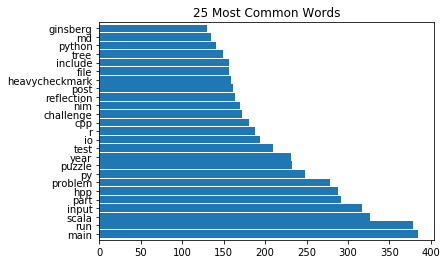

In [34]:
raw_count.sort_values(ascending=False)[0:25].plot.barh(width=.9)
plt.title('25 Most Common Words')

### How does this look for popular languages?

#### Python

In [35]:
python_text = " ".join(df[df.language == "Python"].prepped)
python_words = python_text.split()

In [36]:
python_count = pd.Series(python_words).value_counts()
python_count.head(15)

py                163
python             56
part               47
run                39
hand               35
model              33
puzzle             33
image              30
tensorflow         29
input              29
training           28
p                  28
heavycheckmark     26
repo               23
searching          23
dtype: int64

Text(0.5, 1.0, 'Python 10 Most Common Words')

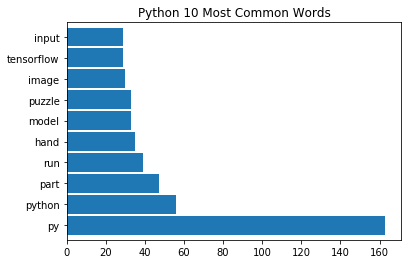

In [37]:
python_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Python 10 Most Common Words')

#### Haskell

In [38]:
haskell_text = " ".join(df[df.language == "Haskell"].prepped)
haskell_words = haskell_text.split()

In [39]:
haskell_count = pd.Series(haskell_words).value_counts()
haskell_count.head(15)

reflection         164
db                  96
dr                  91
challenge           89
h                   66
dh                  64
dg                  64
benchmark           52
dc                  50
mdday               49
mddaybenchmarks     48
haskell             47
b                   44
test                43
run                 38
dtype: int64

Text(0.5, 1.0, 'Haskell 10 Most Common Words')

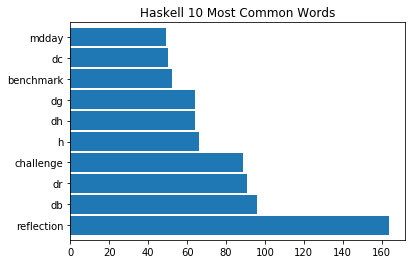

In [40]:
haskell_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Haskell 10 Most Common Words')

#### JavaScript

In [41]:
javascript_text = " ".join(df[df.language == "JavaScript"].prepped)
javascript_words = javascript_text.split()

In [42]:
javascript_count = pd.Series(javascript_words).value_counts()
javascript_count.head(15)

run                64
j                  59
star               49
puzzle             48
npm                41
part               40
index              38
test               36
year               34
input              33
simulation         27
net                26
post               26
adventofcodeday    25
node               25
dtype: int64

Text(0.5, 1.0, 'JavaScript 10 most common words')

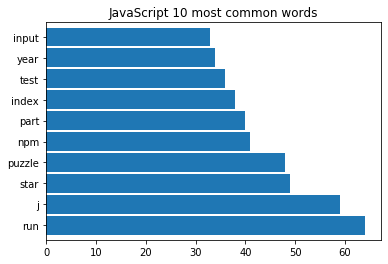

In [43]:
javascript_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('JavaScript 10 most common words')

#### Rust

In [44]:
rust_text = " ".join(df[df.language == "Rust"].prepped)
rust_words = rust_text.split()

In [45]:
rust_count = pd.Series(rust_words).value_counts()
rust_count.head(15)

r               105
target           56
reddit           50
cargo            47
input            44
rust             39
run              38
twitter          30
b                29
www              29
comment          28
daysolutions     25
main             24
part             21
x                20
dtype: int64

Text(0.5, 1.0, 'Rust 10 Most Common Words')

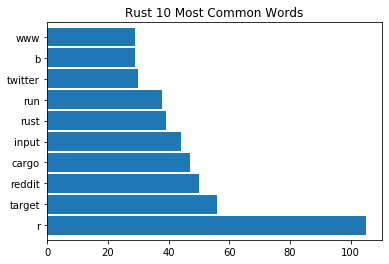

In [46]:
rust_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Rust 10 Most Common Words')

#### Clojure

In [47]:
clojure_text = " ".join(df[df.language == "Clojure"].prepped)
clojure_words = clojure_text.split()

In [48]:
clojure_count = pd.Series(clojure_words).value_counts()
clojure_count.head(15)

clj         66
clojure     41
test        20
run         18
input       13
script      13
part        11
one          9
tree         8
py           8
license      7
circleci     7
year         7
problem      7
python       7
dtype: int64

Text(0.5, 1.0, 'Clojure 10 most common words')

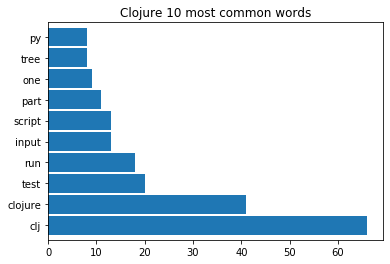

In [49]:
clojure_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Clojure 10 most common words')

#### Java

In [50]:
java_text = " ".join(df[df.language == "Java"].prepped)
java_words = java_text.split()

In [51]:
java_count = pd.Series(java_words).value_counts()
java_count.head(15)

java         48
problem      33
tree         26
statement    25
run          23
input        21
main         17
language     14
sbaars       12
io           11
img          11
shield       11
part         10
badge         9
completed     8
dtype: int64

Text(0.5, 1.0, 'Java 10 most common words')

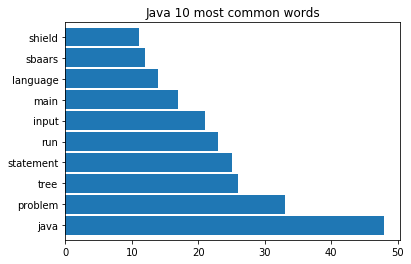

In [52]:
java_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Java 10 most common words')

### Does the length of the README vary by programming language?

### Do different programming languages use a different number of unique words?

# Model

[Top](#Github-NLP-Project)

Here we will look at the raw count, term frequency (tf), and inverse document frequency (idf). Then we will use that information to create models. We will train several different models and pick the best one. We will test the best model and evaluate the results. 

In [53]:
# Create a data frame with raw count and tf
tf_df = pd.DataFrame({'raw_count': raw_count})
tf_df = tf_df.assign(term_frequency = lambda df: df.raw_count / df.raw_count.sum())
tf_df.raw_count.max()
tf_df.head()

,raw_count,term_frequency
main,385,0.012584
run,378,0.012355
scala,327,0.010688
input,317,0.010361
part,292,0.009544


In [54]:
# Create a function that takes in a word and returns the idf of that word
def idf(word):
    n_occurrences = sum([1 for doc in df.prepped if word in doc])
    n_docs = len(df.prepped)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [55]:
# Create a list of unique words
unique_words = pd.Series(' '.join(df.prepped).split()).unique()
len(unique_words)

4483

In [56]:
idf_df = pd.DataFrame(dict(word = unique_words))
idf_df = idf_df.assign(idf = lambda df: df.word.apply(idf))
idf_df = idf_df.set_index('word').sort_values(by='idf', ascending = False)
idf_df.head(25)

,idf
word,
wip,5.627621
detectorutils,5.627621
commonly,5.627621
precision,5.627621
summarize,5.627621
precisionrecall,5.627621
curve,5.627621
accuracy,5.627621
frozeninferencegraph,5.627621


In [57]:
df.language.value_counts()

Python              39
JavaScript          35
Haskell             25
Rust                19
Clojure             15
Go                  14
Java                13
Kotlin              12
C#                  10
Ruby                10
Elixir               9
Scala                8
C++                  8
R                    7
OCaml                5
Jupyter Notebook     4
TypeScript           4
PHP                  3
C                    3
Elm                  2
F#                   2
Swift                2
Perl                 2
Pony                 2
Scheme               2
Julia                2
Crystal              2
HTML                 2
Nim                  1
Ada                  1
Shell                1
Mathematica          1
PowerShell           1
PureScript           1
Erlang               1
Eiffel               1
D                    1
Reason               1
TSQL                 1
APL                  1
Haxe                 1
Dart                 1
Coq                  1
Racket     

#### It will not be realistic or benefitial to train and predict languages with a very small sample size. To accomodate for this, we create the label 'Other'. Other includes all languages that have less than 9 samples. This leaves us with the top 11 languages and the label Other for a total of 12 programming languages. 

In [58]:
df['language'] = df['language'].replace({'C++':'Other', 'Scala':'Other', 'OCaml':'Other','C':'Other', 'Elm':'Other', 'Pony':'Other', 'HTML':'Other', 'Perl':'Other','APL':'Other', 'Haxe':'Other', 'Racket':'Other', 'PureScript':'Other', 'Coq':'Other','F#':'Other', 'PHP':'Other', 'TSQL':'Other', 'Crystal':'Other', 'Nim':'Other', 'Shell':'Other', 'Eiffel':'Other', 'Mathematica':'Other', 'Swift':'Other', 'Reason':'Other', 'TypeScript':'Other', 'Jupyter Notebook':'Python', 'Scheme':'Other', 'Powershell':'Other', 'Julia':'Other', 'PowerShell':'Other', 'Ada':'Other', 'Erlang':'Other', 'Smalltalk':'Other', 'D':'Other', 'Dart':'Other', 'R':'Other'})

In [59]:
df.language.value_counts()

Other         73
Python        43
JavaScript    35
Haskell       25
Rust          19
Clojure       15
Go            14
Java          13
Kotlin        12
Ruby          10
C#            10
Elixir         9
Name: language, dtype: int64

In [60]:
sum(df.language.value_counts())

278

## Split

In [61]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.prepped)
y = df.language

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

## Baseline: Predict Most Popular Language

#### Baseline Accuracy: 26%

Our data consists of 276 readme entries. Our most popular programming language is 'Other' with 73. If we were to guess Other for every language, we would be correct 26% of the time. Our final model must beat this baseline accuracy of 26%.

## Model 1: Logistic Regression

In [62]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

### Train Evaluation

In [63]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.57%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0        6       0   0        0     0           0       0      0   
Go           0        0       0   4        0     0           0       0      0   
Haskell      0        0       0   0       12     0           0       0      0   
Java         0        0       0   0        0     5           0       0      0   
JavaScript   0        1       0   1        0     0          21       0      0   
Kotlin       0        0       0   0        0     0           0       3      0   
Other        8        5       7   5        7     5           7       6     57   
Python       0        0       0   1        1     1           0       1      1   
Ruby         0        0       0   0        0     0           0       0      0   
Rust         0        0       0   0        0     0           0       0 

## Model 2: Decision Tree

In [64]:
# Create
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=123)
# Fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [65]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

### Train Evaluation

In [66]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.12%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0       11       0   0        0     0           0       0      0   
Elixir       0        0       7   0        0     0           0       0      0   
Haskell      0        0       0   0       11     0           0       0      0   
Java         0        0       0   0        0    10           0       0      0   
JavaScript   2        0       0   3        0     0           7       1      0   
Kotlin       0        0       0   0        0     0           0       7      0   
Other        6        1       0   8        9     1          21       2     58   
Python       0        0       0   0        0     0           0       0      0   
Ruby         0        0       0   0        0     0           0       0      0   
Rust         0        0       0   0        0     0           0       0 

## Model 3: Random Forest

In [67]:
# Create
rf = RandomForestClassifier(min_samples_leaf=3, max_depth=9, random_state=123)
# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [68]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

### Train Evaluation

In [69]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 55.86%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0        1       0   0        0     0           0       0      0   
Go           0        0       0   4        0     0           0       0      0   
Haskell      0        0       0   0        4     1           0       0      0   
Java         0        0       0   0        0     2           0       0      0   
JavaScript   0        0       0   1        0     0          21       0      1   
Kotlin       0        0       0   0        0     0           0       3      0   
Other        7       10       7   5       14     7           7       7     55   
Python       1        1       0   1        1     1           0       0      1   
Ruby         0        0       0   0        0     0           0       0      0   
Rust         0        0       0   0        1     0           0       0 

## Model 4: K-Nearest Neighbors

In [70]:
# Create
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform')
# Fit
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [71]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = knn.predict(X_train)
test['predicted'] = knn.predict(X_test)

### Train Evaluation

In [72]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 66.67%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
C#           2        0       0   0        1     0           1       0      5   
Clojure      0       12       0   0        0     0           2       0      1   
Elixir       0        0       6   0        0     0           0       0      0   
Go           0        0       0   7        0     1           1       2      2   
Haskell      1        0       0   1       14     0           0       0      1   
Java         0        0       0   0        0     6           0       0      1   
JavaScript   1        0       0   1        1     2          23       2     11   
Kotlin       0        0       0   0        0     0           0       4      1   
Other        2        0       1   1        2     1           1       2     32   
Python       2        0       0   1        1     1           0       0 

## Testing our Best Model

[Top](#Github-NLP-Project)

Our best perfoming model is the decision tree. Let's run our model on the test data to see how it does. 


In [73]:
# Create
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=123)
# Fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [74]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

In [75]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 53.57%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0        1       0   0        0     0           0       0      0   
Elixir       0        0       2   0        0     0           0       0      0   
Haskell      0        0       0   0        3     0           0       0      0   
Java         1        0       0   0        0     1           0       0      0   
JavaScript   0        0       0   0        0     0           2       0      0   
Kotlin       0        0       0   0        0     0           0       1      1   
Other        1        2       0   3        2     0           4       1     14   
Python       0        0       0   0        0     0           1       0      0   
Ruby         0        0       0   0        0     1           0       0      0   
Rust         0        0       0   0        0     0           0       0 

#### Conclusion: Our best model is the decision tree. When given unseen test data, our model returns an accuracy of about 52%. This is significant, given our model is making its predictions from 12 options. It also vastly outperforms our baseline model, which had an accuracy of 26%.

### Build a function that will take in the text of a README file, and tries to predict the programming language.